<a id="top"></a>
# 04 · Resumen y visualización de resultados

**Qué hace este notebook**  
Inspecciona los **resultados de entrenamientos continual** y presenta:
- Un **resumen por experimento** y otro **por tarea** (historiales).
- Lectura de **telemetría de emisiones** de *CodeCarbon* (`emissions.csv`) y del log ligero `telemetry.jsonl`.
- Un **CSV enriquecido** con rendimiento + emisiones para análisis posterior.
- Gráficos rápidos: MAE, olvido relativo y emisiones (kg CO₂e), además de un *scatter* rendimiento vs. emisiones.

**Fuentes de datos**
- `outputs/continual_*/*/manifest.json` (o `metrics.json`) → historiales por tarea.
- `outputs/continual_*/continual_results.json` → métricas a nivel de experimento.
- `outputs/continual_*/emissions.csv` (si *CodeCarbon* estaba activo en el run).
- `outputs/continual_*/telemetry.jsonl` (eventos del runner).

## ✅ Prerrequisitos
- Haber ejecutado **03_TRAIN_CONTINUAL.ipynb** (para poblar `outputs/continual_*`).
- (Opcional) Tener *CodeCarbon* instalado/activado para disponer de `emissions.csv`.

---

<a id="toc"></a>
## Índice

- [1) Imports y rutas base](#sec-01)  
- [2) Utilidades de parseo y lectura robusta](#sec-02)  
- [3) Resumen “continual” (por run)](#sec-03)  
- [4) Resumen de entrenamiento por tarea (manifest/metrics)](#sec-04)  
- [5) Gráficos rápidos](#sec-05)  
- [6) Inspección de un experimento concreto](#sec-06)
- [7) Inspección detallada: CodeCarbon + Telemetry (último run)](#sec-07)  
- [8) Agregados por preset/método con emisiones](#sec-08)


<a id="sec-01"></a>
## 1) Imports y rutas base

**Objetivo**  
Configurar el entorno mínimo de lectura/visualización:
- Detectar la **raíz del repo** (`ROOT`) tanto si ejecutas desde `notebooks/` como desde la raíz.  
- Definir `OUT = ROOT / "outputs"` como carpeta base de resultados.

> No modifica ni reescribe archivos de los runs: **solo lee** y visualiza.  

[↑ Volver al índice](#toc)


In [ ]:
from pathlib import Path
import json, re, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Raíz del repo (soporta ejecutar desde notebooks/ o raíz)
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

OUT = ROOT / "outputs"
print("ROOT:", ROOT); print("OUT :", OUT)


ROOT: /home/cesar/proyectos/TFM_SNN
OUT : /home/cesar/proyectos/TFM_SNN/outputs


<a id="sec-02"></a>
## 2) Utilidades de parseo y lectura robusta

**Objetivo**  
Apoyarse en utilidades **canónicas** del proyecto (`src.utils_exp`) para:
- `safe_read_json`: lectura tolerante a errores (devuelve `{}` si no existe o está corrupto).  
- `parse_exp_name`: extraer metadatos desde el nombre de la carpeta `continual_*` (preset, método, encoder, seed, modelo…).  
- `build_runs_df` y `aggregate_and_show`: construir un **DataFrame** consolidado por experimento y, opcionalmente, generar **agregados** y guardarlos.

Se añaden *helpers* locales para:
- Encontrar el primer JSON disponible por **tarea** (`manifest.json` o `metrics.json`).  
- Leer **CodeCarbon** (`emissions.csv`) de forma **tolerante a versiones** (columnas pueden variar según versión).  
- Leer el último evento de `telemetry.jsonl` para capturar `elapsed_sec` y `emissions_kg` si el runner los registró.

[↑ Volver al índice](#toc)


In [ ]:
# Utilidades canónicas (parseo, lectura, dataframe y agregados)
from src.results_io import build_runs_df, aggregate_and_show, parse_exp_name, safe_read_json

print("[INFO] Usando utilidades de src.utils_exp")

# Helpers locales
from pathlib import Path

def find_first_file(folder: Path, candidates=("manifest.json", "metrics.json")) -> Path | None:
    for c in candidates:
        p = folder / c
        if p.exists():
            return p
    return None

# ---------- Helpers CodeCarbon / Telemetry ----------
def _lower_map(cols):
    return {c.lower().strip(): c for c in cols}

def read_codecarbon_summary(exp_dir: Path) -> dict:
    """
    Devuelve un dict con resumen de CodeCarbon para un experimento:
    {'emissions_kg', 'duration_s', 'energy_kwh', 'cpu_kwh','gpu_kwh','ram_kwh'}
    Robusto a distintas versiones de CodeCarbon.
    """
    csv_path = exp_dir / "emissions.csv"
    if not csv_path.exists():
        return {}
    try:
        df = pd.read_csv(csv_path)
        if df.empty:
            return {}
        cmap = _lower_map(df.columns)

        def get_col(name_candidates, default=None):
            for name in name_candidates:
                if name in cmap:
                    return df[cmap[name]]
            return default

        # Última fila suele traer el acumulado del run
        last = df.iloc[-1]

        # Emisiones (kg CO2e)
        emissions_kg = None
        for k in ("emissions", "emissions_kg", "emission", "co2e"):
            if k in cmap:
                emissions_kg = float(last[cmap[k]])
                break

        # Duración (segundos)
        duration_s = None
        for k in ("duration_s", "duration", "total_duration_s"):
            if k in cmap:
                duration_s = float(last[cmap[k]])
                break

        # Energía (kWh)
        # Preferimos energy_consumed; si no existe, sumamos cpu/gpu/ram
        energy_kwh = None
        if "energy_consumed" in cmap:
            energy_kwh = float(last[cmap["energy_consumed"]])
        else:
            cpu_kwh = float(last[cmap["cpu_energy"]]) if "cpu_energy" in cmap else np.nan
            gpu_kwh = float(last[cmap["gpu_energy"]]) if "gpu_energy" in cmap else np.nan
            ram_kwh = float(last[cmap["ram_energy"]]) if "ram_energy" in cmap else np.nan
            parts = [v for v in [cpu_kwh, gpu_kwh, ram_kwh] if pd.notna(v)]
            energy_kwh = float(np.sum(parts)) if parts else None

        # Componentes (si existen)
        cpu_kwh = float(last[cmap["cpu_energy"]]) if "cpu_energy" in cmap else None
        gpu_kwh = float(last[cmap["gpu_energy"]]) if "gpu_energy" in cmap else None
        ram_kwh = float(last[cmap["ram_energy"]]) if "ram_energy" in cmap else None

        return {
            "emissions_kg": emissions_kg,
            "duration_s": duration_s,
            "energy_kwh": energy_kwh,
            "cpu_kwh": cpu_kwh,
            "gpu_kwh": gpu_kwh,
            "ram_kwh": ram_kwh,
        }
    except Exception:
        return {}

def read_telemetry_last(exp_dir: Path) -> dict:
    """
    Lee el último evento de telemetry.jsonl (si existe).
    Devuelve {'elapsed_sec':..., 'emissions_kg':...} si está.
    """
    f = exp_dir / "telemetry.jsonl"
    if not f.exists():
        return {}
    try:
        last = {}
        with f.open("r", encoding="utf-8") as fh:
            for line in fh:
                last = json.loads(line)
        keep = {}
        if "elapsed_sec" in last:
            keep["telemetry_elapsed_sec"] = float(last["elapsed_sec"])
        if "emissions_kg" in last and last["emissions_kg"] is not None:
            keep["telemetry_emissions_kg"] = float(last["emissions_kg"])
        return keep
    except Exception:
        return {}


[INFO] Usando utilidades de src.utils_exp


<a id="sec-03"></a>
## 3) Resumen “continual” + emisiones (por run)

**Objetivo**  
Construir un **resumen a nivel de experimento** a partir de `continual_results.json` y **enriquecerlo** con:
- **Emisiones** de *CodeCarbon* (`emissions.csv`): `emissions_kg`, `energy_kwh`, `cpu_kwh`, `gpu_kwh`, `ram_kwh`, `duration_s`.  
- **Telemetría del runner** (`telemetry.jsonl`): `telemetry_elapsed_sec`, `telemetry_emissions_kg` (si existen).

**Salida adicional**
- Se guarda `outputs/summary/runs_with_emissions.csv` (rendimiento + emisiones) listo para graficar o compartir.

> Si no hay `emissions.csv` (no activaste CodeCarbon), las columnas de emisiones quedarán **vacías** para esos runs.

[↑ Volver al índice](#toc)


In [3]:
# Resumen por experimento (usa build_runs_df)
df_runs = build_runs_df(OUT)
print(f"runs en resumen: {len(df_runs)}")

# Enriquecer con CodeCarbon + Telemetry
rows_cc = []
for exp_dir in sorted(OUT.glob("continual_*")):
    cc = read_codecarbon_summary(exp_dir)
    tel = read_telemetry_last(exp_dir)
    row = {"exp": exp_dir.name}
    row.update(cc)
    row.update(tel)
    # métricas derivadas útiles
    if cc.get("emissions_kg") is not None and cc.get("duration_s"):
        row["kg_per_hour"] = cc["emissions_kg"] / max(1e-9, cc["duration_s"]/3600.0)
    rows_cc.append(row)

df_cc = pd.DataFrame(rows_cc)

if df_runs.empty and df_cc.empty:
    display(df_runs)
else:
    df_merged = (
        df_runs.merge(df_cc, on="exp", how="left")
        .sort_values(["preset","method","encoder","lambda","seed"], na_position="last", ignore_index=True)
    )
    display(df_merged)

    # Guarda resumen enriquecido
    out_summary_dir = OUT / "summary"
    out_summary_dir.mkdir(parents=True, exist_ok=True)
    df_merged.to_csv(out_summary_dir / "runs_with_emissions.csv", index=False)
    print(f"[OK] Guardado resumen enriquecido en {out_summary_dir/'runs_with_emissions.csv'}")

# (Opcional) además, el agregado bonito habitual
_ = aggregate_and_show(df_runs, OUT)


runs en resumen: 54


,exp,preset,method,lambda,encoder,model,seed,c1_name,c2_name,c1_mae,...,lambda_num,telemetry_elapsed_sec,emissions_kg,duration_s,energy_kwh,cpu_kwh,gpu_kwh,ram_kwh,telemetry_emissions_kg,kg_per_hour
0,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,accurate,as-snn_gr_0.3,1.59168,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.165532,...,1.591680e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...,accurate,ewc,7e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.165532,...,7.000000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,continual_accurate_naive_rate_model-PilotNetSN...,accurate,naive,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.177562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,continual_accurate_rehearsal_buf_3000_rr_20+ew...,accurate,rehearsal_buf_3000_rr_20+ewc,1e+09,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.173464,...,1.000000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,continual_accurate_sa-snn_k10_tau24_th1-2_p300...,accurate,sa-snn_k10_tau24_th1-2_p3000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.126147,...,NaN,37398.521138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,continual_accurate_sa-snn_k6_tau42_th1-2_p7000...,accurate,sa-snn_k6_tau42_th1-2_p7000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.113966,...,NaN,27858.284536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,continual_accurate_sa-snn_k8_tau30_th1-2_p5000...,accurate,sa-snn_k8_tau30_th1-2_p5000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.128430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,continual_accurate_sa-snn_k8_tau32_th1-2_p5000...,accurate,sa-snn_k8_tau32_th1-2_p5000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.135996,...,NaN,31801.961172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,continual_accurate_sa-snn_k9_tau28_th1-2_p5000...,accurate,sa-snn_k9_tau28_th1-2_p5000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.119714,...,NaN,23419.875446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,continual_fast_as-snn_gr_0.3_lam_1.59168_rate_...,fast,as-snn_gr_0.3,1.59168,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.170549,...,1.591680e+00,95.225739,0.000434,87.845237,0.002493,0.000168,0.001854,0.000471,0.000434,0.017784


[OK] Guardado resumen enriquecido en /home/cesar/proyectos/TFM_SNN/outputs/summary/runs_with_emissions.csv


,exp,preset,method,lambda,encoder,model,seed,c1_name,c2_name,c1_mae,c1_after_c2_mae,c1_forgetting_mae_abs,c1_forgetting_mae_rel_%,c2_mae,lambda_num
0,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,accurate,as-snn_gr_0.3,1.59168,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.165532,0.200847,0.035314,21.333848,0.217257,1.591680e+00
1,continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...,accurate,ewc,7e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.165532,0.166002,0.000470,0.283758,0.221053,7.000000e+08
2,continual_accurate_naive_rate_model-PilotNetSN...,accurate,naive,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.177562,0.239561,0.061999,34.916516,0.220103,NaN
3,continual_accurate_rehearsal_buf_3000_rr_20+ew...,accurate,rehearsal_buf_3000_rr_20+ewc,1e+09,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.173464,0.173046,-0.000419,-0.241270,0.206640,1.000000e+09
4,continual_accurate_sa-snn_k10_tau24_th1-2_p300...,accurate,sa-snn_k10_tau24_th1-2_p3000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.126147,0.228015,0.101867,80.752836,0.142088,NaN
5,continual_accurate_sa-snn_k6_tau42_th1-2_p7000...,accurate,sa-snn_k6_tau42_th1-2_p7000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.113966,0.141973,0.028008,24.575525,0.129492,NaN
6,continual_accurate_sa-snn_k8_tau30_th1-2_p5000...,accurate,sa-snn_k8_tau30_th1-2_p5000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.128430,0.169603,0.041173,32.058913,0.137881,NaN
7,continual_accurate_sa-snn_k8_tau32_th1-2_p5000...,accurate,sa-snn_k8_tau32_th1-2_p5000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.135996,0.163795,0.027799,20.440879,0.138079,NaN
8,continual_accurate_sa-snn_k9_tau28_th1-2_p5000...,accurate,sa-snn_k9_tau28_th1-2_p5000000,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.119714,0.150836,0.031122,25.997377,0.135245,NaN
9,continual_fast_as-snn_gr_0.3_lam_1.59168_rate_...,fast,as-snn_gr_0.3,1.59168,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.170549,0.174574,0.004025,2.359856,0.225020,1.591680e+00


Guardado: /home/cesar/proyectos/TFM_SNN/outputs/summary/continual_summary_agg.csv


,preset,método,codificador,λ,MAE Tarea1 (media),Olvido T1 (%) (media),MAE Tarea2 (media),MAE Tarea1 (σ),Olvido T1 (%) (σ),MAE Tarea2 (σ),n (semillas)
0,accurate,as-snn_gr_0.3,rate,1.59168,0.1655,21.3338,0.2173,,,,1
1,accurate,ewc,rate,7e+08,0.1655,0.2838,0.2211,,,,1
2,accurate,naive,rate,NaN,0.1776,34.9165,0.2201,,,,1
3,accurate,rehearsal_buf_3000_rr_20+ewc,rate,1e+09,0.1735,-0.2413,0.2066,,,,1
4,accurate,sa-snn_k10_tau24_th1-2_p3000000,rate,NaN,0.1261,80.7528,0.1421,,,,1
5,accurate,sa-snn_k6_tau42_th1-2_p7000000,rate,NaN,0.1140,24.5755,0.1295,,,,1
6,accurate,sa-snn_k8_tau30_th1-2_p5000000,rate,NaN,0.1284,32.0589,0.1379,,,,1
7,accurate,sa-snn_k8_tau32_th1-2_p5000000,rate,NaN,0.1360,20.4409,0.1381,,,,1
8,accurate,sa-snn_k9_tau28_th1-2_p5000000,rate,NaN,0.1197,25.9974,0.1352,,,,1
9,fast,as-snn_gr_0.3,rate,1.59168,0.1717,1.1848,0.2245,0.0017,1.6618,0.0007,2


<a id="sec-04"></a>
## 4) Resumen de entrenamiento por tarea (manifest/metrics)

**Objetivo**  
Leer, para cada carpeta `outputs/continual_*/*task_*`, el archivo `manifest.json` (o `metrics.json`) y extraer:
- **Hiperparámetros efectivos** por tarea: `epochs`, `batch_size`, `lr`, `amp`, `seed`.  
- **Historial de pérdidas**: últimas `train_loss` y `val_loss`.

Notas:
- Si estaba activo **Early Stopping**, el número real de épocas útiles puede ser **menor** que el configurado.  
- Si una carpeta de tarea no contiene `manifest.json` ni `metrics.json`, simplemente se ignora en este resumen.  
- Este bloque **no recalcula** métricas; solo muestra lo **registrado** durante el entrenamiento.

[↑ Volver al índice](#toc)


In [4]:
task_rows = []
for exp_dir in sorted(OUT.glob("continual_*")):
    for task_dir in sorted(exp_dir.glob("task_*")):
        jf = find_first_file(task_dir)
        if jf is None:
            continue
        man = safe_read_json(jf)
        history = man.get("history", {})
        train_hist = history.get("train_loss", [])
        val_hist   = history.get("val_loss", [])
        task_rows.append({
            "exp": exp_dir.name,
            "task": task_dir.name,
            "epochs": man.get("epochs"),
            "batch_size": man.get("batch_size"),
            "lr": man.get("lr"),
            "amp": man.get("amp"),
            "seed": man.get("seed"),
            "train_last": train_hist[-1] if train_hist else np.nan,
            "val_last": val_hist[-1] if val_hist else np.nan,
        })
df_tasks = pd.DataFrame(task_rows)
print(f"tareas encontradas: {len(df_tasks)}")
display(df_tasks.sort_values(["exp","task"], ignore_index=True) if not df_tasks.empty else df_tasks)


tareas encontradas: 110


,exp,task,epochs,batch_size,lr,amp,seed,train_last,val_last
0,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,task_1_circuito1,20,16,0.00075,True,42,0.118225,0.045692
1,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,task_2_circuito2,20,16,0.00075,True,42,0.320577,0.071794
2,continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...,task_1_circuito1,20,16,0.00075,True,42,0.048774,0.045692
3,continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...,task_2_circuito2,20,16,0.00075,True,42,8.926241,0.092901
4,continual_accurate_naive_rate_model-PilotNetSN...,task_1_circuito1,20,16,0.00075,True,42,0.041319,0.049537
...,...,...,...,...,...,...,...,...,...
105,continual_std_rehearsal_buf_3000_rr_10+ewc_lam...,task_2_circuito2,8,56,0.00050,True,42,0.383868,0.079713
106,continual_std_rehearsal_buf_3000_rr_10_rate_mo...,task_1_circuito1,8,56,0.00050,True,42,0.012114,0.026605
107,continual_std_rehearsal_buf_3000_rr_10_rate_mo...,task_2_circuito2,8,56,0.00050,True,42,0.014330,0.035263
108,continual_std_sa-snn_k10_tau10_th1-2_p2000000_...,task_1_circuito1,8,96,0.00050,True,42,0.016428,0.027149


<a id="sec-05"></a>
## 5) Gráficos rápidos (MAE, olvido, emisiones)

**Objetivo**  
Ofrecer una vista rápida y comparativa:
- Barras de **`c1_mae`** por experimento (calidad en la primera tarea).  
- Barras de **olvido relativo** (`c1_forgetting_mae_rel_%`) si la columna existe y hay ≥2 tareas.  
- **NUEVO**: Barras de **emisiones totales (kg CO₂e)** por experimento y *scatter* **MAE vs emisiones** (trade-off rendimiento/sostenibilidad), usando el CSV enriquecido.

> Gráficos intencionadamente simples para inspección rápida. Para informes finales, exporta el CSV y construye figuras personalizadas.

[↑ Volver al índice](#toc)


/tmp/ipykernel_1125/1628373534.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


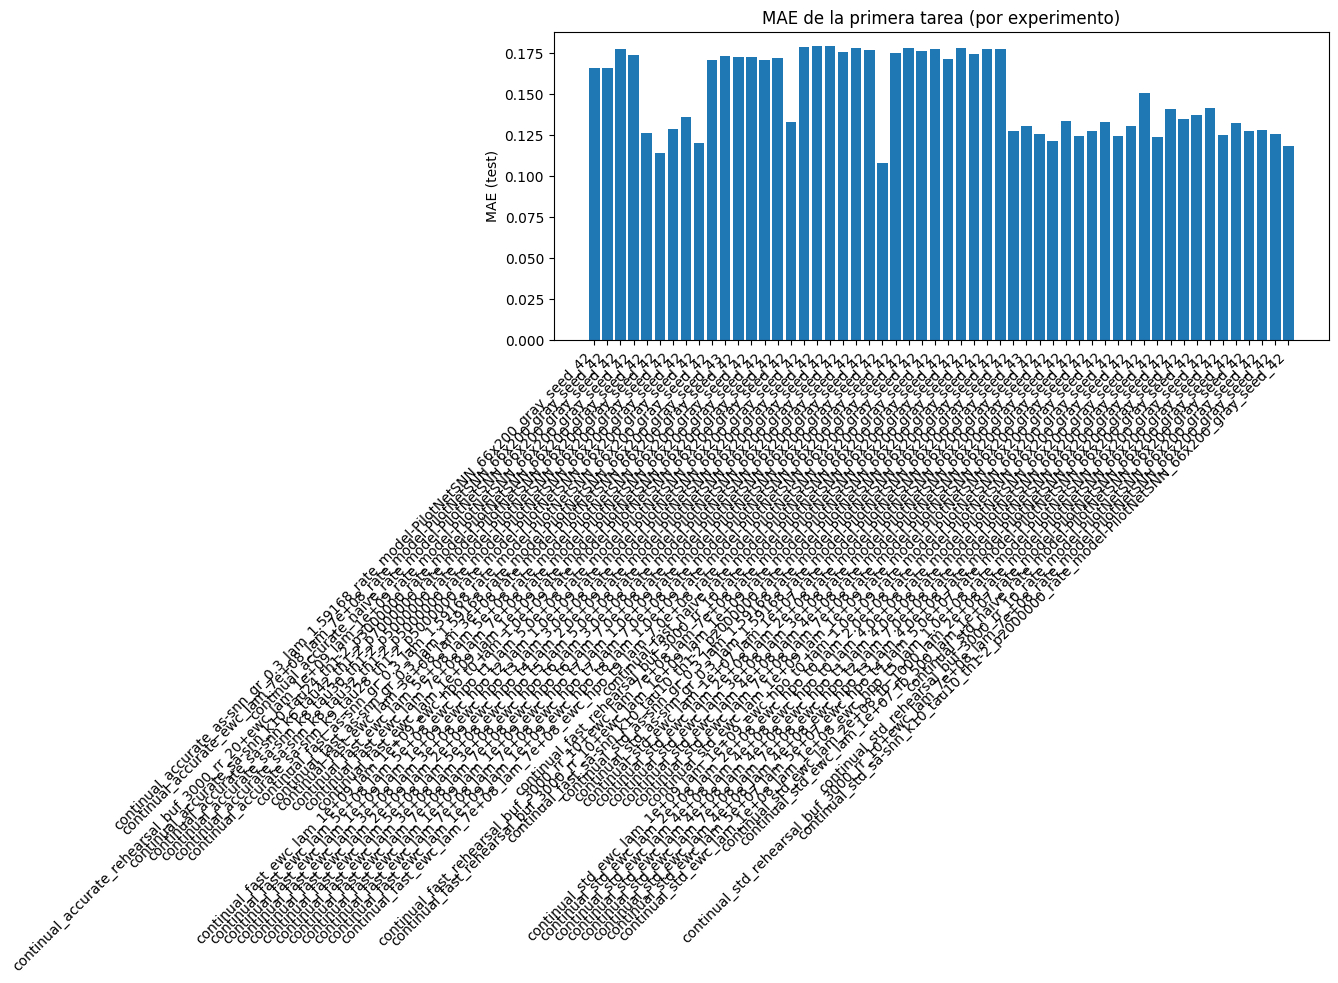

/tmp/ipykernel_1125/1628373534.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


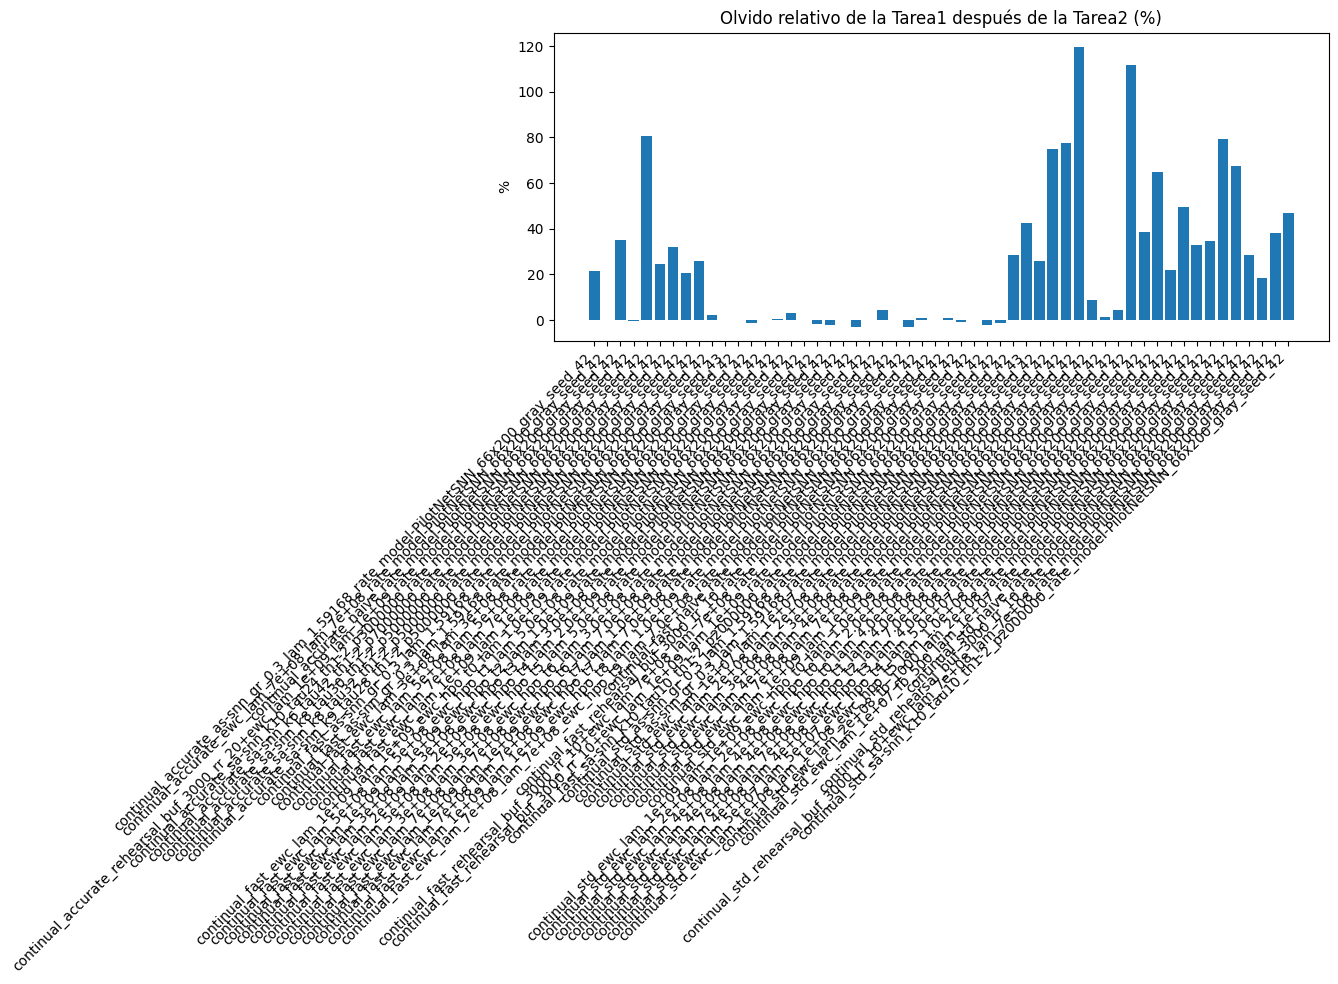

/tmp/ipykernel_1125/1628373534.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


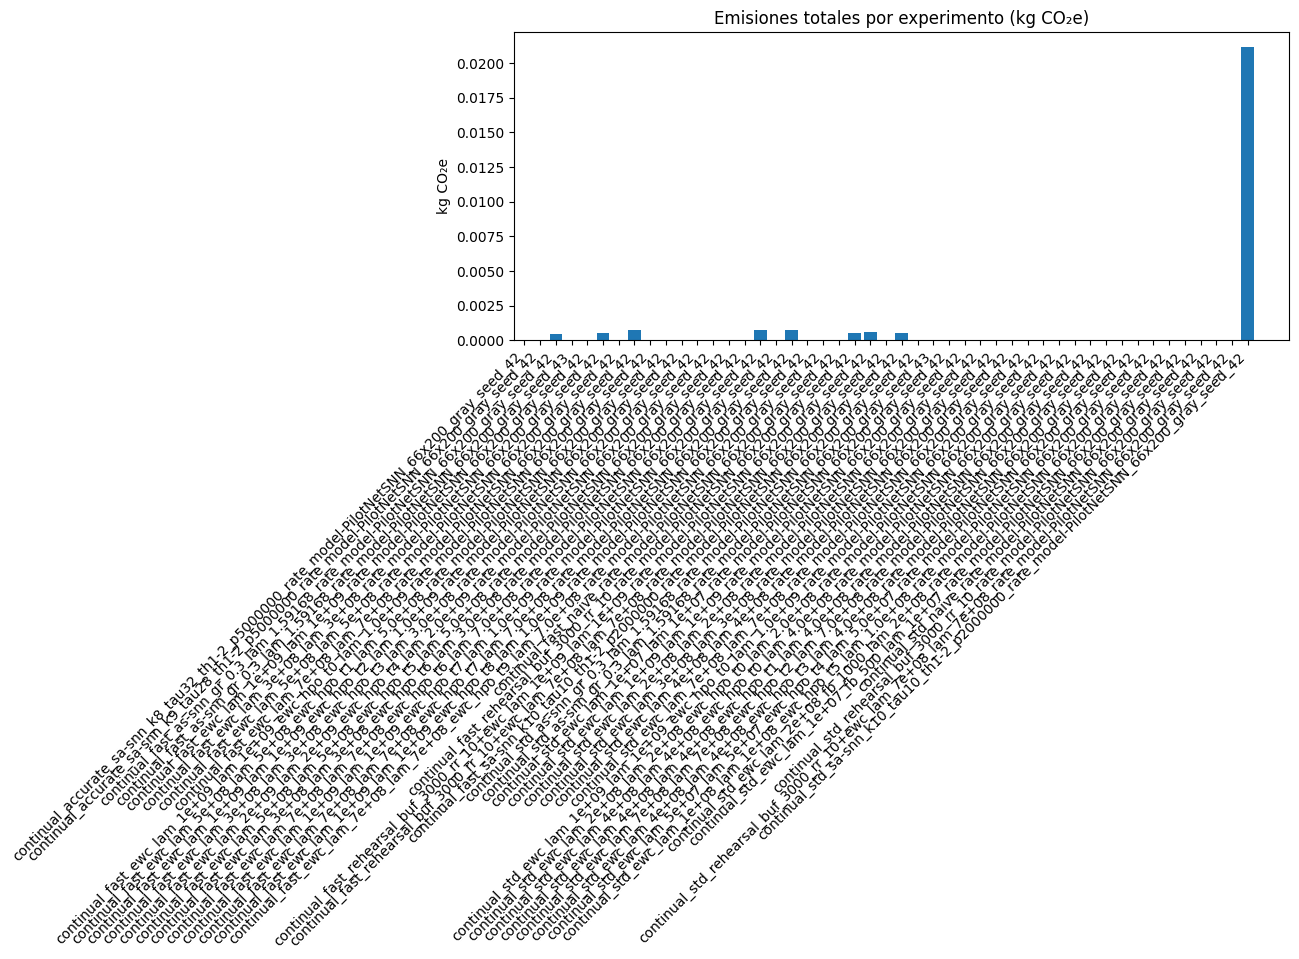

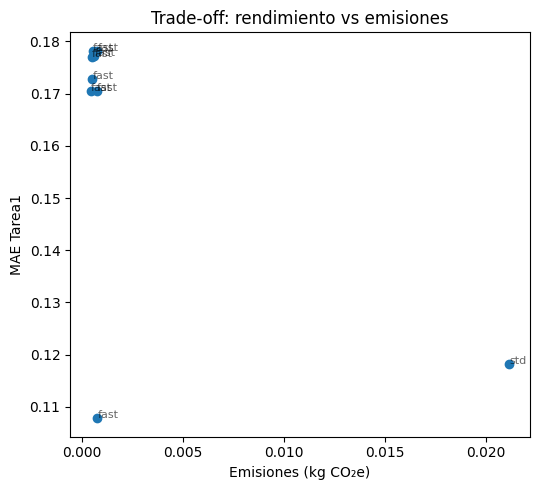

In [5]:
if df_runs.empty:
    print("No hay datos en df_runs; ejecuta entrenos en 03_TRAIN_CONTINUAL.ipynb primero.")
else:
    # Orden consistente por nombre de experimento
    order = df_runs["exp"].tolist()

    # MAE Tarea1
    plt.figure(figsize=(10,4))
    plt.bar(order, df_runs["c1_mae"])
    plt.title("MAE de la primera tarea (por experimento)")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("MAE (test)")
    plt.tight_layout()
    plt.show()

    # Olvido relativo (%)
    if "c1_forgetting_mae_rel_%" in df_runs.columns and df_runs["c1_forgetting_mae_rel_%"].notna().any():
        plt.figure(figsize=(10,4))
        plt.bar(order, df_runs["c1_forgetting_mae_rel_%"])
        plt.title("Olvido relativo de la Tarea1 después de la Tarea2 (%)")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("%")
        plt.tight_layout()
        plt.show()

    # --- NUEVO: Emisiones (si existe df_cc o el merge ya guardado) ---
    summary_path = OUT / "summary" / "runs_with_emissions.csv"
    if summary_path.exists():
        df_me = pd.read_csv(summary_path)
        if "emissions_kg" in df_me.columns and df_me["emissions_kg"].notna().any():
            plt.figure(figsize=(10,4))
            plt.bar(df_me["exp"], df_me["emissions_kg"])
            plt.title("Emisiones totales por experimento (kg CO₂e)")
            plt.xticks(rotation=45, ha="right")
            plt.ylabel("kg CO₂e")
            plt.tight_layout()
            plt.show()

            # Eficiencia: MAE vs Emisiones
            if "c1_mae" in df_me.columns:
                plt.figure(figsize=(5.5,5))
                plt.scatter(df_me["emissions_kg"], df_me["c1_mae"])
                for _, r in df_me.iterrows():
                    plt.annotate(r["preset"], (r["emissions_kg"], r["c1_mae"]), fontsize=8, alpha=0.6)
                plt.xlabel("Emisiones (kg CO₂e)")
                plt.ylabel("MAE Tarea1")
                plt.title("Trade-off: rendimiento vs emisiones")
                plt.tight_layout()
                plt.show()


<a id="sec-06"></a>
## 6) Inspección de un experimento concreto

**Objetivo**  
Abrir el `continual_results.json` del **experimento más reciente** (o el que indiques manualmente) y mostrar su contenido completo (diccionario).
- Útil para revisar **todas** las claves guardadas por el *runner* y verificar cálculos.  
- Si no existen carpetas `continual_*`, se informa en consola y no se imprime nada.

> Pista: revisa las secciones por **tarea** y los bloques `after_*` que reflejan el rendimiento **tras** aprender nuevas tareas (base del cálculo de olvido).

[↑ Volver al índice](#toc)


In [6]:
exps = sorted(OUT.glob("continual_*"), key=lambda p: p.stat().st_mtime, reverse=True)
if not exps:
    print("No hay carpetas continual_* en outputs/.")
else:
    exp_dir = exps[0]   # cámbialo si quieres otro
    cfile = exp_dir / "continual_results.json"
    print("Mostrando:", cfile if cfile.exists() else "(no existe continual_results.json)")
    if cfile.exists():
        pprint(safe_read_json(cfile))


Mostrando: (no existe continual_results.json)


<a id="sec-07"></a>
## 7) Inspección detallada: CodeCarbon + Telemetry (último run)

**Objetivo**  
Mostrar los **últimos registros** de `emissions.csv` (CodeCarbon) y la **última entrada** de `telemetry.jsonl` para el run más reciente:
- Tabla con las **últimas filas** de `emissions.csv` (para ver el cierre del tracker).  
- Resumen rápido: `emissions_kg`, `energy_kwh`, `duration_s`.  
- Último evento de `telemetry.jsonl` (suele incluir `elapsed_sec` y, si estaba disponible, `emissions_kg`).

> Útil para validar que el tracker **cerró bien** y que los tiempos/emisiones concuerdan con lo registrado por el runner.

[↑ Volver al índice](#toc)


In [7]:
# Mostrar los últimos registros de CodeCarbon y la última entrada de telemetry.jsonl
if exps:
    exp_dir = exps[0]
    csv_path = exp_dir / "emissions.csv"
    telem_path = exp_dir / "telemetry.jsonl"

    if csv_path.exists():
        df_cc_last = pd.read_csv(csv_path).tail(10)
        display(df_cc_last)
        # Totales rápidos:
        from math import isnan
        summary = read_codecarbon_summary(exp_dir)
        if summary:
            print("[CC resumen] emissions_kg=", summary.get("emissions_kg"),
                  " energy_kwh=", summary.get("energy_kwh"),
                  " duration_s=", summary.get("duration_s"))

    if telem_path.exists():
        last_line = {}
        with telem_path.open("r", encoding="utf-8") as fh:
            for line in fh:
                last_line = json.loads(line)
        print("[telemetry last]", last_line)


[telemetry last] {'ts': 1760208850.5068278, 'event': 'run_start', 'preset': 'accurate', 'method': 'sa-snn_k10_tau28_th1-2_p4000000', 'encoder': 'rate', 'T': 30, 'batch_size': 32, 'amp': True, 'out_dir': '/home/cesar/proyectos/TFM_SNN/outputs/continual_accurate_sa-snn_k10_tau28_th1-2_p4000000_rate_model-PilotNetSNN_66x200_gray_seed_42', 'platform': 'Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.39', 'python': '3.12.3', 'cpu_count': 12, 'torch': '2.8.0+cu129', 'cuda_available': True, 'gpu_name': 'NVIDIA GeForce RTX 4080 Laptop GPU', 'gpu_capability': '8.9', 'gpu_mem_total_gb': 11.99}


<a id="sec-08"></a>
## 8) Agregados por preset/método con emisiones

**Objetivo**  
Calcular y mostrar agregados **por `preset`** y **por `method`** a partir de `runs_with_emissions.csv`:
- `runs` (conteo), `mean_c1_mae`, `sum_emissions_kg`, `mean_emissions_kg`.

> Te da una visión global del **trade-off** por configuración: calidad media y huella total/media.  
> Si no existe el CSV enriquecido, ejecuta antes la **Sección 3**.

[↑ Volver al índice](#toc)


In [8]:
summary_path = OUT / "summary" / "runs_with_emissions.csv"
if summary_path.exists():
    df_me = pd.read_csv(summary_path)

    # Agregado por preset
    if "preset" in df_me.columns:
        agg_preset = (df_me
                      .groupby("preset", dropna=False)
                      .agg(
                          runs=("exp","count"),
                          mean_c1_mae=("c1_mae","mean"),
                          sum_emissions_kg=("emissions_kg","sum"),
                          mean_emissions_kg=("emissions_kg","mean")
                      )
                      .reset_index())
        display(agg_preset)

    # Agregado por método
    if "method" in df_me.columns:
        agg_method = (df_me
                      .groupby("method", dropna=False)
                      .agg(
                          runs=("exp","count"),
                          mean_c1_mae=("c1_mae","mean"),
                          sum_emissions_kg=("emissions_kg","sum"),
                          mean_emissions_kg=("emissions_kg","mean")
                      )
                      .reset_index())
        display(agg_method)
else:
    print("No se encontró summary/runs_with_emissions.csv (ejecuta antes la celda 3).")


,preset,runs,mean_c1_mae,sum_emissions_kg,mean_emissions_kg
0,accurate,9,0.145149,0.00000,NaN
1,fast,23,0.170580,0.00472,0.00059
2,std,22,0.130015,0.02117,0.02117


,method,runs,mean_c1_mae,sum_emissions_kg,mean_emissions_kg
0,as-snn_gr_0.3,5,0.153323,0.000434,0.000434
1,ewc,11,0.147067,0.001206,0.000603
2,ewc_ewc_hpo_t0_lam_1.0e+09,2,0.128515,0.000000,NaN
3,ewc_ewc_hpo_t0_lam_2.0e+08,1,0.130145,0.000000,NaN
4,ewc_ewc_hpo_t0_lam_4.0e+08,1,0.150774,0.000000,NaN
5,ewc_ewc_hpo_t1_lam_4.0e+08,1,0.123754,0.000000,NaN
6,ewc_ewc_hpo_t1_lam_5.0e+08,1,0.178656,0.000000,NaN
7,ewc_ewc_hpo_t2_lam_1.0e+09,1,0.178892,0.000000,NaN
8,ewc_ewc_hpo_t2_lam_7.0e+08,1,0.140915,0.000000,NaN
9,ewc_ewc_hpo_t3_lam_3.0e+08,1,0.178959,0.000000,NaN
